In [1]:
import torch 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import resnet50
import numpy as np
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((255, 255)),
                              ])
train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_dataset',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_test_dataset',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=False)

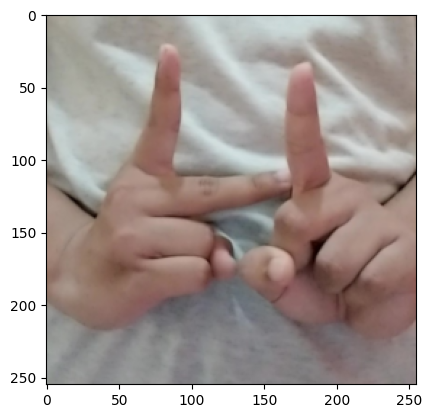

In [3]:
def showImage(img):
    img = np.array(img)
    img = img.transpose(1,2,0)
    plt.imshow(img)

x = next(iter((train_loader)))[0][2]
showImage(x)

t5= transforms.RandomAffine(
    degrees=0,  
    translate=(0.5, 0))
x4= t5(x)

#### Training resnet50 with all the 8*26 observations

In [4]:
model2 = resnet50(pretrained=True).to('cuda')
num_feature = model2.fc.in_features
model2.fc = nn.Linear(num_feature,26)

for param in model2.parameters():
    param.requires_grad = False

for param in model2.fc.parameters():
    param.requires_grad = True

c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
import torch.nn.functional as F

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = model2
        # Définir la loss function
        self.criterion = nn.CrossEntropyLoss()
        
        num_classes = 26
        # Définir les métriques
        self.train_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        
        self.val_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.val_recall = TM.Recall(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.train_acc(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.val_acc(preds, targets)
        self.val_recall(preds, targets)  
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        self.log('val_recall', self.val_recall, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        # Optimiser uniquement les paramètres du classifieur (la dernière couche)
        return optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)


In [6]:
# my_module = Module()
# trainer = L.Trainer(max_epochs=45)
# trainer.fit(
#     my_module,
#     train_loader,
#     test_loader
# )

#### Use 8**26 observations to Train the SIMCLR Algorithm and use 5*26 for the fine tuning on the classification head

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((255, 255))  
])

train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_1',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=True)

#### Evaluate the model perfomence with several transformations one by one 

In [8]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import random

transformation_groups = {
    "translations": [
        transforms.RandomAffine(degrees=0, translate=(0.1, 0)),  # Translation de 10%
        transforms.RandomAffine(degrees=0, translate=(0.2, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.3, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.4, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.5, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.6, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.7, 0)),  
        transforms.RandomAffine(degrees=0, translate=(0.8, 0))   
    ],
    "rotations": [
        transforms.RandomAffine(degrees=10, translate=(0, 0)),  # Rotation de 10°
        transforms.RandomAffine(degrees=20, translate=(0, 0)),  
        transforms.RandomAffine(degrees=30, translate=(0, 0)),  
        transforms.RandomAffine(degrees=40, translate=(0, 0)),  
        transforms.RandomAffine(degrees=50, translate=(0, 0)),  
        transforms.RandomAffine(degrees=60, translate=(0, 0)),  
        transforms.RandomAffine(degrees=70, translate=(0, 0)),  
        transforms.RandomAffine(degrees=80, translate=(0, 0))   
    ],
    "ResizedCrop": [
        transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0)),  # Découpe aléatoire redimensionnée
        transforms.RandomResizedCrop(size=64, scale=(0.5, 1.0)),   
        transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0)),  
        transforms.RandomResizedCrop(size=128, scale=(0.6, 0.9)),  
        transforms.RandomResizedCrop(size=128, scale=(0.7, 1.0)),  
        transforms.RandomResizedCrop(size=128, scale=(0.3, 0.7)),  
        transforms.RandomResizedCrop(size=192, scale=(0.5, 1.0)),  
        transforms.RandomResizedCrop(size=32, scale=(0.5, 1.0))    
    ],
    "ColorJitter": [
        transforms.ColorJitter(brightness=0.5),  # Variation de luminosité
        transforms.ColorJitter(contrast=0.5),   
        transforms.ColorJitter(saturation=0.5),  
        transforms.ColorJitter(hue=0.3),        
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  
        transforms.ColorJitter(saturation=0.3, hue=0.1),        
        transforms.ColorJitter(brightness=0.4, saturation=0.4), 
        transforms.ColorJitter(contrast=0.4, hue=0.2)           
    ],
    "GaussianBlur": [
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Flou gaussien
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2)),  
        transforms.GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 3)),  
        transforms.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 4)),  
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.5, 1)),  
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.8)),  
        transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.2, 1)),  
        transforms.GaussianBlur(kernel_size=(7, 5), sigma=(0.3, 2))   
    ],
    "RandomErasing": [
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # Effacement aléatoire
        transforms.RandomErasing(p=0.4, scale=(0.1, 0.2), ratio=(0.3, 3.3)),   
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.3), ratio=(0.3, 3.3)),   
        transforms.RandomErasing(p=0.2, scale=(0.01, 0.2), ratio=(0.5, 1.5)),  
        transforms.RandomErasing(p=0.3, scale=(0.05, 0.25), ratio=(0.4, 2.5)),  
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.2, 1.5)),   
        transforms.RandomErasing(p=0.4, scale=(0.03, 0.3), ratio=(0.4, 1.5)),   
        transforms.RandomErasing(p=0.3, scale=(0.01, 0.15), ratio=(0.2, 1.0))   
    ],
    "RandomHorizontalFlip": [
        transforms.RandomHorizontalFlip(p=0.5),  # Inversion horizontale
        transforms.RandomHorizontalFlip(p=0.7),  
        transforms.RandomHorizontalFlip(p=0.3),  
        transforms.RandomHorizontalFlip(p=0.9),  
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.6),  
        transforms.RandomHorizontalFlip(p=0.4),  
        transforms.RandomHorizontalFlip(p=0.8)   
    ],
    "RandomVerticalFlip": [
        transforms.RandomVerticalFlip(p=0.5),    # Inversion verticale
        transforms.RandomVerticalFlip(p=0.7),    
        transforms.RandomVerticalFlip(p=0.3),    
        transforms.RandomVerticalFlip(p=0.9),   
        transforms.RandomVerticalFlip(p=0.2),    
        transforms.RandomVerticalFlip(p=0.6),    
        transforms.RandomVerticalFlip(p=0.4),    
        transforms.RandomVerticalFlip(p=0.8)      
    ],
    "others": [
        transforms.RandomRotation(degrees=30),    # Rotation aléatoire
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
        transforms.ColorJitter(brightness=0.2),  
        transforms.RandomAffine(degrees=0, translate=(0.1, 0)),  
        transforms.RandomGrayscale(p=0.2),       
        transforms.RandomAffine(degrees=10),     
        transforms.RandomAffine(degrees=20)       
    ],
    "Bad_Mixed" : [
        transforms.ColorJitter(brightness=0.82, contrast=0.72),  
        transforms.RandomErasing(p=0.4, scale=(0.1, 0.2), ratio=(0.3, 3.3)),
        transforms.RandomGrayscale(p=0.2),  
        transforms.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 4)),  
        transforms.ColorJitter(brightness=0.2, contrast=0.82),  
        transforms.ColorJitter(brightness=0.72, contrast=0.2),   
        transforms.ColorJitter(brightness=0.82, contrast=0.52),
        transforms.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 4)),  
    ]
}

# Sélectionner les groupes de transformations à utiliser
def get_transformations(active_groups):
    selected_transformations = []
    for group in active_groups:
        selected_transformations.extend(transformation_groups[group])
    return selected_transformations

In [ ]:
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image 

# Charger le modèle pré-entraîné Mask R-CNN
netwk = maskrcnn_resnet50_fpn(pretrained=True)

# Fonction pour choisir une transformation aléatoire parmi les groupes sélectionnés
def random_choose(transformation_list):
    p = random.randint(0, len(transformation_list) - 1)
    return transformation_list[p]

# Définir les transformations de couleur
color_jitter_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.52, contrast=0.52),
])

# Générer deux batchs d'images transformées en fonction des transformations actives
def generate_batch(batch_image, active_groups):
    # Obtenir les transformations actives (à définir dans ta fonction get_transformations)
    selected_transformations = get_transformations(active_groups)
    transform_batch_1 = random_choose(selected_transformations)
    transform_batch_2 = transforms.Compose([
        transforms.ColorJitter(brightness=0.82, contrast=0.72),       
    ])
    
    first_batch = []
    second_batch = []
    netwk.eval()
    
    # Effectuer des prédictions sans gradient
    with torch.no_grad():
        prediction_mask = netwk(batch_image)

    batch_image = np.array(batch_image)
    print("le premier batch", batch_image.shape)

    for index, image in enumerate(batch_image):
        boxes = prediction_mask[index]['boxes'].cpu().numpy()
        masks = prediction_mask[index]['masks'].cpu().numpy()
        scores = prediction_mask[index]['scores'].cpu().numpy()
        
        for i, box in enumerate(boxes):
            if scores[i] > 0:
                x1, y1, x2, y2 = box.astype(int)
                mask = masks[i, 0] > 0  # Obtention du masque
                
                # Transposer l'image pour le traitement
                image_permuted = image.transpose(1, 2, 0) 
                colored_object = image_permuted[y1:y2, x1:x2].copy()
                colored_object = Image.fromarray((colored_object * 255).astype(np.uint8), mode='RGB')

                # Appliquer les transformations différentes sur le même objet
                colored_object_transformed_1 = transform_batch_1(colored_object)
                colored_object_transformed_2 = transform_batch_2(colored_object)

                # Convertir en tableau numpy et normaliser
                colored_object_transformed_1 = np.array(colored_object_transformed_1) / 255.0
                colored_object_transformed_2 = np.array(colored_object_transformed_2) / 255.0
                
                # Redimensionner les objets transformés pour qu'ils correspondent à la taille de la boîte
                colored_object_transformed_1 = Image.fromarray((colored_object_transformed_1 * 255).astype(np.uint8))
                colored_object_transformed_2 = Image.fromarray((colored_object_transformed_2 * 255).astype(np.uint8))

                colored_object_transformed_1 = colored_object_transformed_1.resize((x2 - x1, y2 - y1))
                colored_object_transformed_2 = colored_object_transformed_2.resize((x2 - x1, y2 - y1))

                # Convertir à nouveau en tableau numpy
                colored_object_transformed_1 = np.array(colored_object_transformed_1) / 255.0
                colored_object_transformed_2 = np.array(colored_object_transformed_2) / 255.0

                # Créer des copies de l'image pour les mises à jour
                image_permuted_1 = image_permuted.copy()
                image_permuted_2 = image_permuted.copy()

                # Créer un masque de la taille de l'image transformée
                mask_resized = mask[y1:y2, x1:x2]  # Redimensionner le masque à la taille de la boîte
                mask_resized = np.expand_dims(mask_resized, axis=-1)  # Ajouter une dimension pour correspondre aux images
                
                # Répéter le masque pour qu'il ait la même dimension que l'image (3 canaux)
                mask_resized = np.repeat(mask_resized, 3, axis=-1)  # Répéter le masque pour avoir 3 canaux

                # Appliquer le masque pour mettre à jour l'image
                image_permuted_1[y1:y2, x1:x2][mask_resized] = colored_object_transformed_1[mask_resized]
                image_permuted_2[y1:y2, x1:x2][mask_resized] = colored_object_transformed_2[mask_resized]

                # Clipper les valeurs de l'image
                image_clipped_1 = np.clip(image_permuted_1, 0, 1)
                image_clipped_2 = np.clip(image_permuted_2, 0, 1)
                image_to_save_1 = image_permuted_1.transpose(2,0, 1) 
                image_to_save_2 = image_permuted_2.transpose(2,0, 1)                
                first_batch.append(image_to_save_1)
                second_batch.append(image_to_save_2)
                
                # Afficher les images résultantes
                plt.imshow(image_clipped_1)
                plt.axis('off')
                plt.show()

                plt.imshow(image_clipped_2)
                plt.axis('off')
                plt.show()      
    first_batch = np.array(first_batch)
    second_batch = np.array(second_batch)
    first_batch = torch.from_numpy(first_batch)
    second_batch = torch.from_numpy(second_batch)
    return first_batch, second_batch
# Supposons que train_loader soit déjà défini
test = next(iter(train_loader))[0]
print(test.shape)

# Générer le batch avec les transformations
batch_1, batch_2  =  generate_batch(test, active_groups=['ColorJitter'])


torch.Size([32, 3, 255, 255])


In [19]:
print(batch_2.shape)
print(batch_1.shape)
print(test.shape)

torch.Size([6, 3, 255, 255])
torch.Size([6, 3, 255, 255])
torch.Size([32, 3, 255, 255])


In [11]:
from lightly.loss import NTXentLoss

In [12]:
backbone = resnet50(pretrained=True).to('cuda')

class HeadProjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1000, 200)
        self.fc2 = nn.Linear(200,29)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

Projection = HeadProjection().to('cuda')

class SIMCLR(nn.Module):
    def __init__(self,backbone,projection):
        super().__init__()
        self.backbone = backbone
        self.projection = Projection
    
    def forward(self,x):
        x=self.projection(self.backbone(x))
        return x
simclr_model = SIMCLR(backbone,Projection)

c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Début de l'époque 1
le premier batch (32, 3, 255, 255)


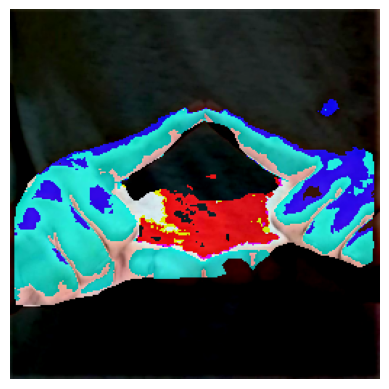

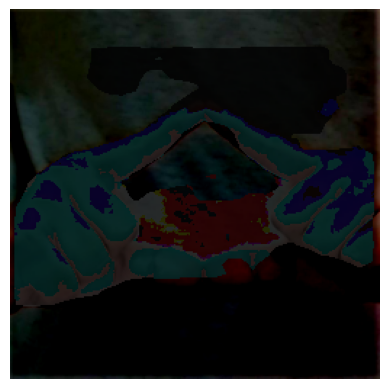

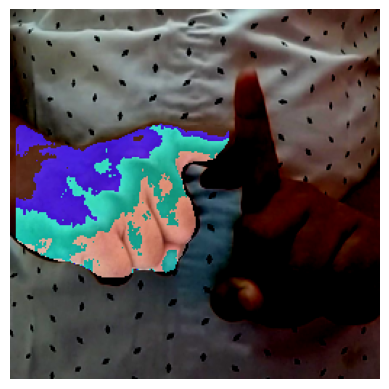

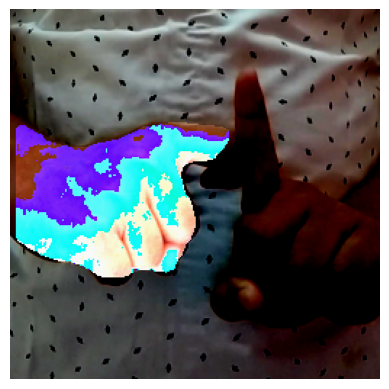

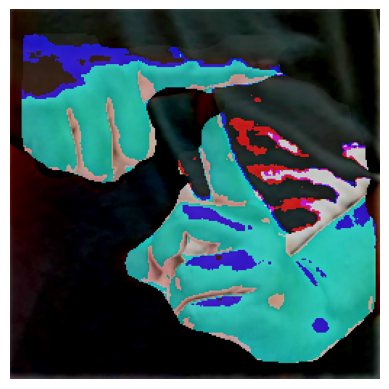

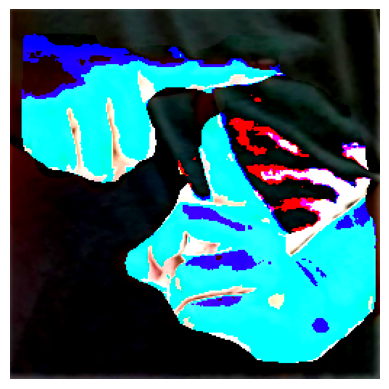

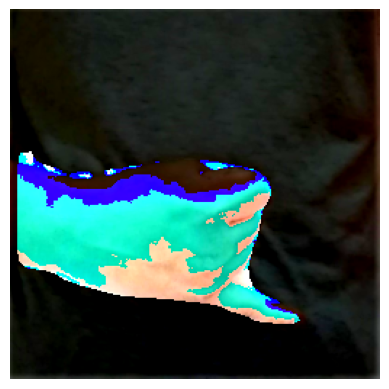

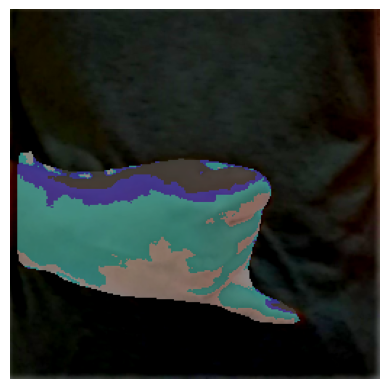

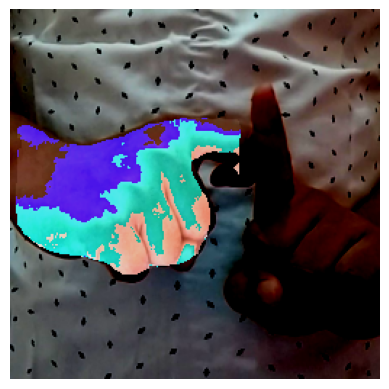

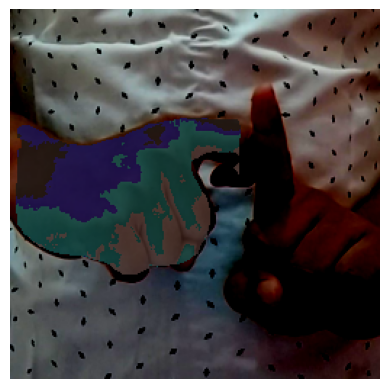

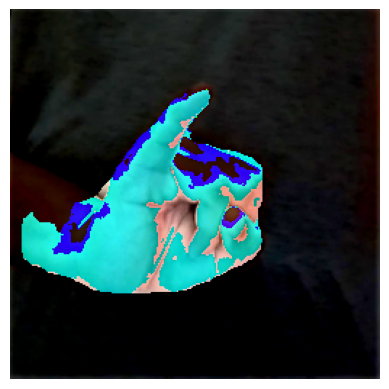

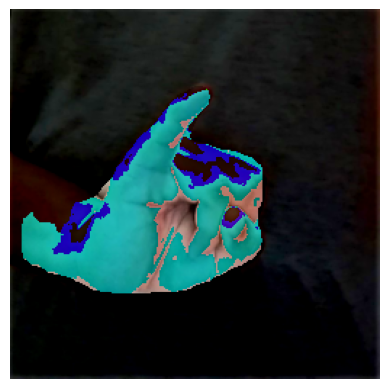

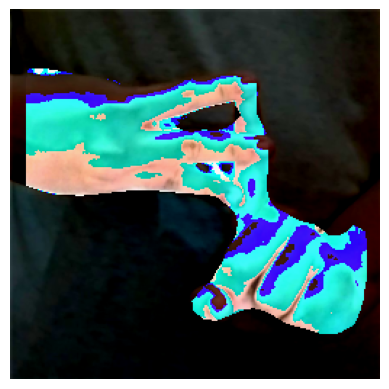

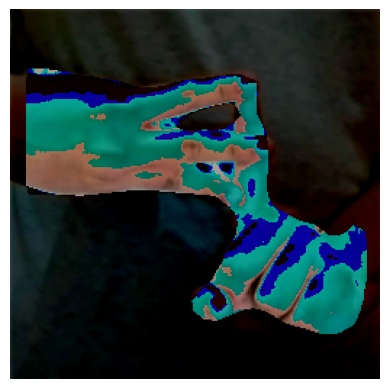

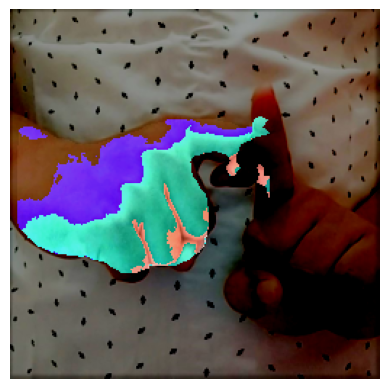

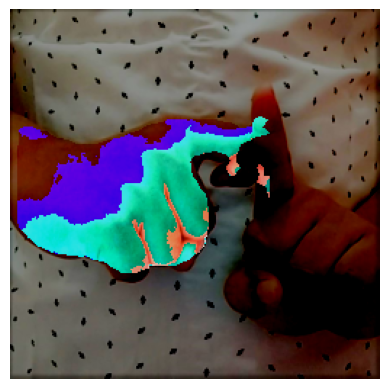

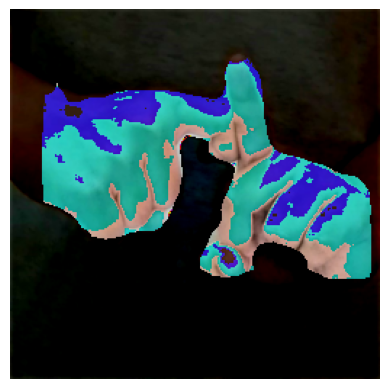

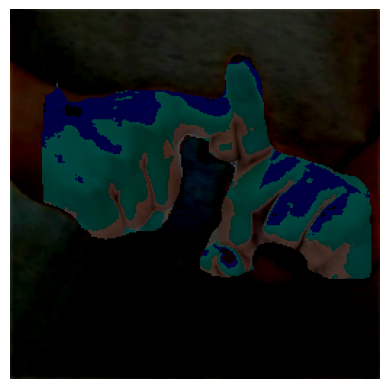

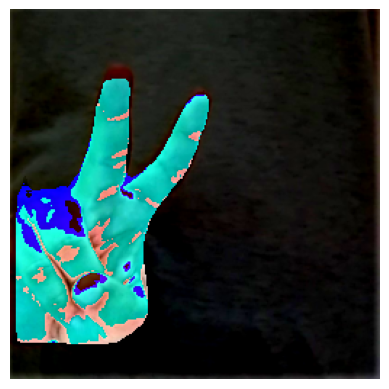

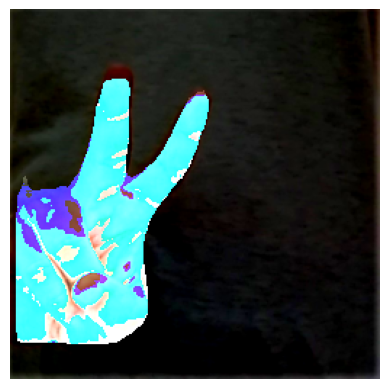

KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt
from pytorch_metric_learning import losses
import torch.optim as optim
criterion = NTXentLoss()
optimizer = optim.SGD(simclr_model.parameters(), lr=0.001)

def training(train_loader, test_loader, num_epochs, active_groups):
    epoch_losses = [] 
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"Début de l'époque {epoch + 1}")
        
        for step, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Générer les deux batchs avec les groupes de transformations activés
            batch_1, batch_2 = generate_batch(data, active_groups)
            batch_1, batch_2 = batch_1.to('cuda'), batch_2.to('cuda')
            
            embedding_batch_1 = simclr_model(batch_1)
            embedding_batch_2 = simclr_model(batch_2)
            loss = criterion(embedding_batch_1,embedding_batch_2)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
    
    # Plot des erreurs d'entraînement
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.grid(True)
    plt.legend()
    plt.savefig('Training_loss_simclr_others_essai_4.png')
    plt.show()

# Exemple d'appel de la fonction avec les groupes actifs
training(train_loader, test_loader, 70, active_groups=["ColorJitter"])


### Finetune the model and just train the classification head with 3**26 observations

In [ ]:
netwk = simclr_model.backbone
num_ftrs = netwk.fc.in_features 
print(num_ftrs)
netwk.fc = nn.Linear(num_ftrs,26)

# Geler toutes les couches du modèle SimCLR pré-entraîné
for param in netwk.parameters():
    param.requires_grad = False

# Débloquer uniquement la dernière couche fully connected (fc)
for param in netwk.fc.parameters():
    param.requires_grad = True


In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_test_dataset',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=False)

In [15]:
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
import torch.nn.functional as F

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = netwk
        # Définir la loss function
        self.criterion = nn.CrossEntropyLoss()
        
        num_classes = 26
        # Définir les métriques
        self.train_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        
        self.val_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.val_recall = TM.Recall(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.train_acc(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.val_acc(preds, targets)
        self.val_recall(preds, targets)  
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        self.log('val_recall', self.val_recall, on_step=True, on_epoch=True)

    def configure_optimizers(self):

        return optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
my_module = Module()
trainer = L.Trainer(max_epochs=50)
trainer.fit(
    my_module,
    train_loader, 
    test_loader
)